<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Heat transport

In this project we will discretize and timestep two systems that describe heat transport. In the first part we will timestep a box model for the Earth's surface temperature with heat buffering provided by the deep ocean. In the second part, we will timestep the one-dimensional diffusion equation which can be used to describe heat moving through a medium (e.g. the ground or still air and water).

Through this project, we will learn how to efficiently timestep ordinary and partial differential equations and examine errors introduced by the numerical discretization. We will also have the chance to explore the timescales and physical processes involved in heat transport in the climate system.

## 1. Climate box model

In this part of the project we will timestep the following box model.

$$ C_s \partial_t T = F(t) - \gamma(T-\theta) $$

$$ C_d \partial_t \theta = \gamma (T-\theta) $$

Here, $T(t)$ represents the global mean surface temperature as a function of time and $\theta(t)$ is the temperature of the deep ocean, both expressed as the difference between the temperature and a pre-industrial equilibrium in units of $^\circ K$. The net surface heat flux, $F(t)$, drives departures from the pre-industrial temperatures. The heat flux between the surface and deep ocean is assumed to be proportional to the difference between the surface and deep ocean temperatures. The constants are the heat capacity of the surface of the Earth, $C_s$, the heat capacity of the deep ocean, $C_d$, and the heat flux coefficient, $\gamma$, all given in units of $W/^\circ K/m^2$.

This model is inspired by a more complicated version of a two box climate model in the paper referenced below. (Interested students might consider adding some additional features from their model, but this is not required for this project).

*Nicklas, J.M., Fox-Kemper, B. and Lawrence, C., 2025. Efficient Estimation of Climate State and Its Uncertainty Using Kalman Filtering with Application to Policy Thresholds and Volcanism. Journal of Climate, 38(5), pp.1235-1270.*

Below, we start to build code to solve these equations. Execute the code cells below.  In some cases you will be asked to add code.

Student tasks are in [Section 1.1](#section1pt1), [Section 1.2](#section1pt2), and [Section 1.3](#section1pt3).

In [520]:
# Before we start, import necessary libraries. Run this cell first.
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

Now, let's define values for the various constants. These values are taken from Nicklas et al., 2025.

In [521]:
C_s = 17 # heat capacity of the Earth's surface (W/m^2/K)
C_d = 156 # heat capacity of the deep ocean (W/m^2/K)
gamma = 0.67 # heat exchange coefficient between surface and deep ocean (W/m^2/K)

Now, let's define a function for F(t), the net surface heat flux (in units of $W/m^2$) that will force our model. This function is here to represent the heat imbalance caused by antropogenic greenhouse gases in the atmosphere. When $F=0$, there is no net surface heat flux. The argument, $t$, is the time in years. We will let $t=0$ denote the start of our additional warming, and we set $F=1$ if $t<200$ years and $F=0$ if $t>200$ years. This corresponds to a very bad-case emissions scenario with an abrupt drop in emissions after 200 years.

In [522]:
def F(t):
    return 1 if t < 200 else 0

Next, set the initial conditions. We will use arrays `T` and `theta`. `T[i]` represents the ith value in the array. We will use `T[0]` and `theta[0]` to hold the initial conditions. Subsequent values, `T[2]`, `T[3]`, etc. will be determined by timestepping the equations. We start by initializing the arrays using numpy and filling them with zeros and then set the initial values (this isn't necessary here since our values are zero anyway, but the code is here to that you can change the initial conditions easily)

In [523]:
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

Now, create an array with the time (in years) corresponding to each time index. Also, calculate the timestep, `dt`.

In [524]:
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

Finally, we are ready to create a for loop to timestep the equations listed at the top of the section.

### 1.1 Student task:
<a id='section1pt1'></a>
Fill in the interior of the for loop to timestep the equations from the start of Section 1 using the Explicit Euler method.

In [525]:
for i in range(0, Nt-1):
    T[i+1] = T[i] + 1/C_s * dt * (F(t[i]) - gamma * (T[i] - theta[i]))
    theta[i+1] = theta[i] + 1/C_d * dt * gamma * (T[i] - theta[i])

After you are finished, run the cell below to plot the results

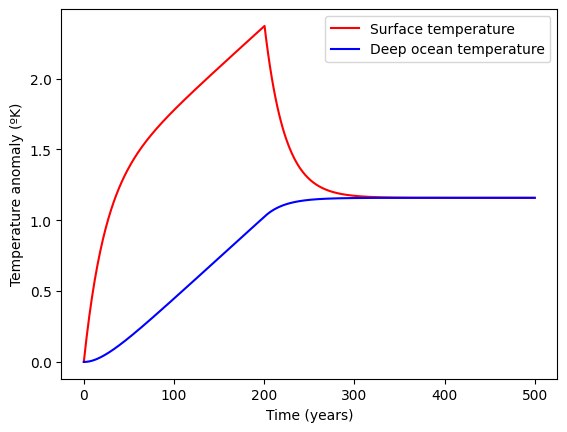

In [526]:
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

### 1.2 Student task
<a id='section1pt2'></a>
Discuss the rates of change the temperature of the Earth's surface and the deep ocean at the start of the model run.  Can you explain these rates by defining characteristic timescales from the box model equations?

At the start of the model run, the temperature of surface increases rapidly, with the temperature of the ocean increasing at a slower rate.
characteristic timescales: T - cs/gamma, theta - cd/gamma
1) at the start, timescale of the ocean is larger than timescale of surface, so it takes longer for the ocean to heat up
2) surface temperature >> ocean temperature, gamma*ocean temperature << 1 so important terms are F and gamma*T. T proportional to 1/c_s t - almost linear until forcing is turned Off
3) No forcing: same timescales as before so surface decreases more quickly (exponential decay) than ocean increases until they reach the same temperature, at which point both derivatives are zero

INSERT DISCUSSION HERE (~1 paragraph)

### 1.3 Student task
<a id='section1pt3'></a>
Modify the forcing function, `F(t)` above with 2-3 scenarios of your choice. Plot the temperature response for each scenario and briefly (2-3 sentences each) describe the temperature responses in each scenario. You will need to replicate some of the code blocks above so that you can produce a new set of plots below.

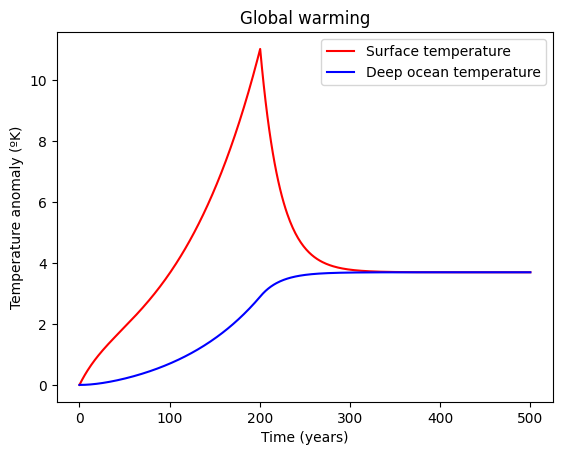

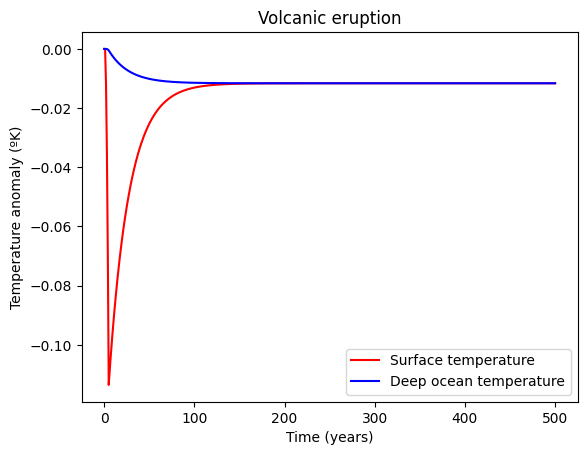

In [527]:
# Add code to make plots here
def plot_scenario(F, title):
  Nt = 500 # number of time steps (including the starting point)
  T = np.zeros(Nt) # surface temperature array
  theta = np.zeros(Nt) # deep ocean temperature array
  T[0] = 0 # initial surface temperature anomaly (ºK)
  theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

  t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
  dt = t[1] - t[0] # timestep in years
  for i in range(0, Nt-1):
    T[i+1] = T[i] + 1/C_s * dt * (F(t[i]) - gamma * (T[i] - theta[i]))
    theta[i+1] = theta[i] + 1/C_d * dt * gamma * (T[i] - theta[i])

  plt.plot(t,T,'r-')
  plt.plot(t,theta,'b-')
  plt.legend(['Surface temperature','Deep ocean temperature'])
  plt.xlabel('Time (years)')
  plt.ylabel('Temperature anomaly (ºK)')
  plt.title(title)
  plt.show()


def F1(t):
    return np.exp(t/100) if t < 200 else 0 #global warming
title1 = 'Global warming'

def F2(t):
    return -t/5 if t < 5 else 0 #volcanic eruption
title2 = 'Volcanic eruption'

plot_scenario(F1, title1)
plot_scenario(F2, title2)


Scenario 1: Exponential increase until t=200 with timescale of 100 years.

Scenario 2: volcanic eruption

## 2. Diffusion equation

In this part of the project we will solve the 1-D diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

We will use second order finite differences to approximate the $x$-derivatives, and we will implement and compare two timestepping methods.

Student tasks are in [Section 2.1](#section2pt1), [Section 2.2](#section2pt2), and [Section 2.3](#section2pt3).

First, let's discretize the second order derivative using finite differences. The function below builds a coefficient matrix, $M$, so that $Mc$ is a discretized version of $\partial^2_x c$, where in our discretized version $c$ is a column vector.

In [528]:
    def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
        dx = x[1] - x[0]  # Infer the uniform grid spacing
        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
        M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
        return M


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [529]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [530]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [531]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [532]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [533]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.06 seconds


and finally, plot the results side-by-side

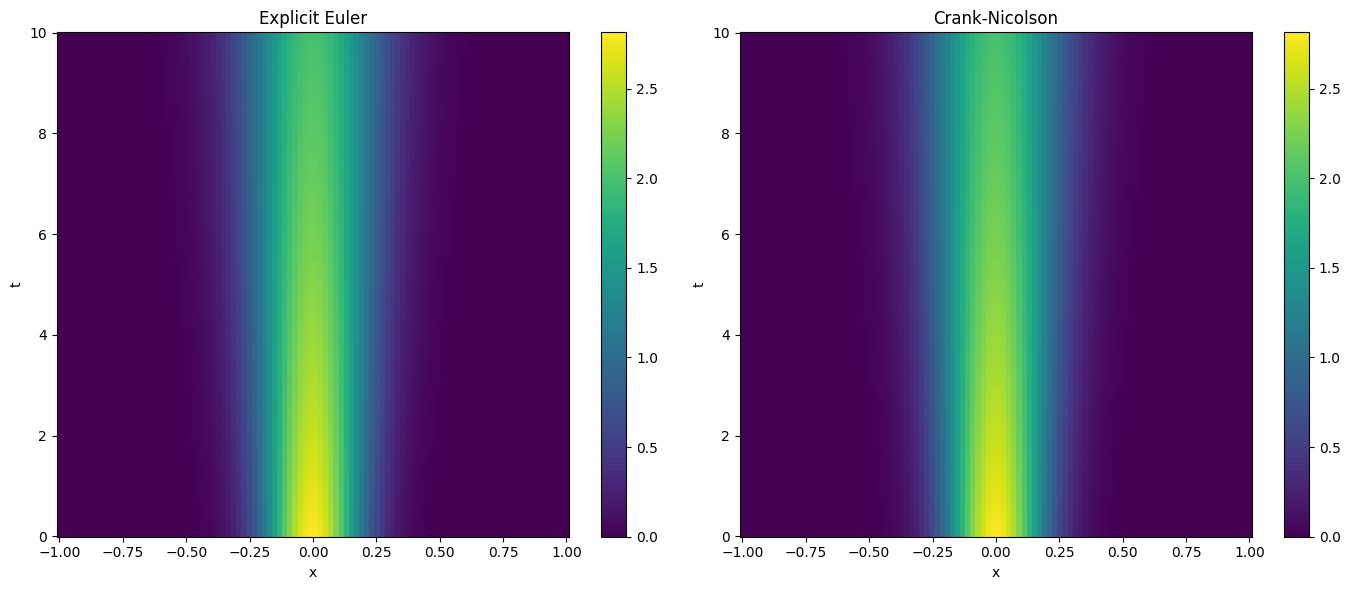

In [534]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have different stability properties. To explore this, try increasing the diffusivity, $\kappa$, and see how each method responds. Discuss your findings below (~2-3 sentences).

\kappa = 0.031 okay but 0.0311 errors come with Euler as axis cannot be NaN or infty
unreliable with
expect the solutions to go to zero, as it is a decaying exponential, for a fixed kappa
can scale t with 1/kappa
CN stable for all of dt when non dimensional so stable for all kappa
euler is unstable for some small t

compare to the analytical stability and find conditions for stability

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

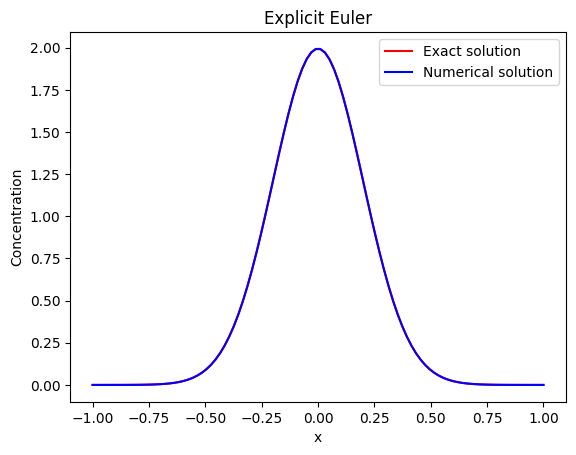

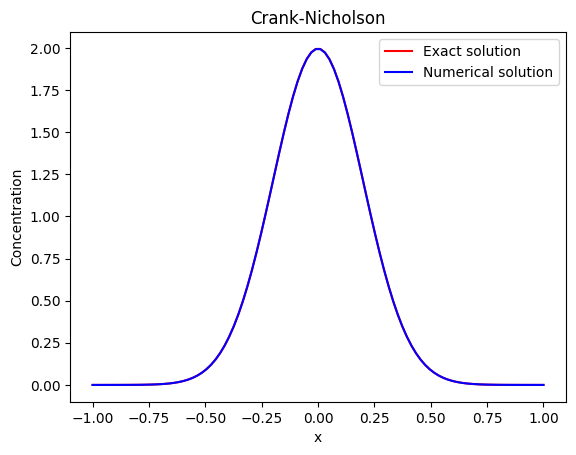

In [535]:
# Add code to plot exact and numerical solutions
t_ic = 10

def true_solution(x,t,z):
  return (1/(4*np.pi*z*(t+t_ic)))**(1/2)*np.exp(-(np.square(x))/(4*z*(t+t_ic)))

y = true_solution(x,10,kappa)


plt.plot(x,c_EE[:,999],'r-')
plt.plot(x,y,'b-')
plt.legend(['Exact solution','Numerical solution'])
plt.xlabel('x')
plt.ylabel('Concentration')
plt.title('Explicit Euler')
plt.show()

plt.plot(x,c_CN[:,999],'r-')
plt.plot(x,y,'b-')
plt.legend(['Exact solution','Numerical solution'])
plt.xlabel('x')
plt.ylabel('Concentration')
plt.title('Crank-Nicholson')
plt.show()


The difference between the exact solution and the numerical approximation can be quantified by various measures of error. The *local error* is the difference between the exact solution and the numerical approximation after one timestep. The *global error* is the difference between the solutions after a fixed amount of time (which includes the accumulation of multiple steps of local error). A method is first order accurate if the global error is linearly proportional to the timestep. A method is second order accurate if the global error varies quadratically with the timestep. Below, calculate and plot the global error for the Explicit Euler and Crank-Nicolson methods and use your results to infer the order of accuracy of each scheme.

PLOT GLOBAL ERROR FOR EACH SCHEME (1-2 figures) AND DISCUSS ORDER OF ACCURACY (2-3 sentences)

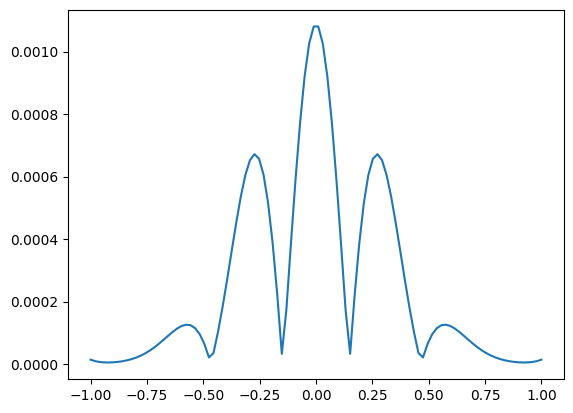

In [536]:
plt.plot(x,np.abs(y-c_EE[:,999]))

Crank-Nicolson method took 0.87 seconds
0.5
Crank-Nicolson method took 0.76 seconds
0.5
Crank-Nicolson method took 0.49 seconds
0.5
Crank-Nicolson method took 0.48 seconds
0.5
Crank-Nicolson method took 0.50 seconds
0.5
Crank-Nicolson method took 0.50 seconds
0.5
Crank-Nicolson method took 0.54 seconds
0.5
Crank-Nicolson method took 0.54 seconds
0.5
Crank-Nicolson method took 0.56 seconds
0.5
Crank-Nicolson method took 0.56 seconds
0.5
Crank-Nicolson method took 0.60 seconds
0.5
Crank-Nicolson method took 0.61 seconds
0.5
Crank-Nicolson method took 0.63 seconds
0.5
Crank-Nicolson method took 0.68 seconds
0.5
Crank-Nicolson method took 0.67 seconds
0.5
Crank-Nicolson method took 0.70 seconds
0.5
Crank-Nicolson method took 0.87 seconds
0.5
Crank-Nicolson method took 0.94 seconds
0.5
Crank-Nicolson method took 0.77 seconds
0.5
Crank-Nicolson method took 0.75 seconds
0.5


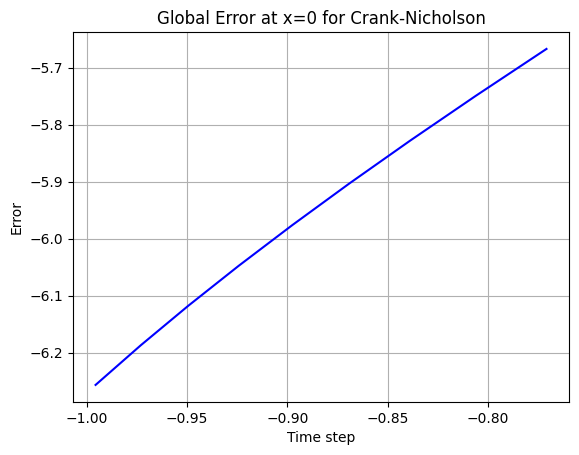

The gradient for the Crank-Nicolson log-log plot is [ 2.17881945 -4.01602282] .


In [574]:
# Add code to plot error here
# Changing the temporal step

euler_error = np.zeros(20)
CN_error = np.zeros(20)
N = np.arange(10,110,5) # A range of number of steps to take to get to t=10
stepsize = np.divide(10,N-1)

def true_solution(x,t,z):
  return (4*np.pi*z*(t+t_ic))**(-1/2)*np.exp((-x**2)/(4*z*(t+t_ic)))

t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
x_start = -1
x_end = 1
Nx = 1601

for i in range(20):
  Nt = N[i]
  t = np.linspace(t_start, t_end, Nt)
  x = np.linspace(x_start, x_end, Nx)
  c_CN = CN(x, t, kappa)
  arg = int(3/4*(Nx-1))
  print(x[arg])
  CN_error[i] = np.abs(true_solution(0.5,t_end,kappa) - c_CN[arg,-1])


plt.plot(np.log10(stepsize[10:19]), np.log10(CN_error[10:19]),'b-')
plt.ylabel('Error')
plt.xlabel('Time step')
plt.title('Global Error at x=0 for Crank-Nicholson')
plt.grid()
plt.show()
m_CN = np.polyfit(np.log10(stepsize[0:19]), np.log10(CN_error[0:19]),1)
print('The gradient for the Crank-Nicolson log-log plot is',m_CN,'.')


Explicit Euler method took 0.04 seconds
0.5
Explicit Euler method took 0.03 seconds
0.5
Explicit Euler method took 0.04 seconds
0.5
Explicit Euler method took 0.04 seconds
0.5
Explicit Euler method took 0.04 seconds
0.5
Explicit Euler method took 0.04 seconds
0.5
Explicit Euler method took 0.05 seconds
0.5
Explicit Euler method took 0.04 seconds
0.5
Explicit Euler method took 0.04 seconds
0.5
Explicit Euler method took 0.04 seconds
0.5
Explicit Euler method took 0.04 seconds
0.5
Explicit Euler method took 0.04 seconds
0.5
Explicit Euler method took 0.04 seconds
0.5
Explicit Euler method took 0.05 seconds
0.5
Explicit Euler method took 0.05 seconds
0.5
Explicit Euler method took 0.04 seconds
0.5
Explicit Euler method took 0.05 seconds
0.5
Explicit Euler method took 0.05 seconds
0.5
Explicit Euler method took 0.05 seconds
0.5
Explicit Euler method took 0.06 seconds
0.5
Explicit Euler method took 0.05 seconds
0.5
Explicit Euler method took 0.06 seconds
0.5
Explicit Euler method took 0.05 

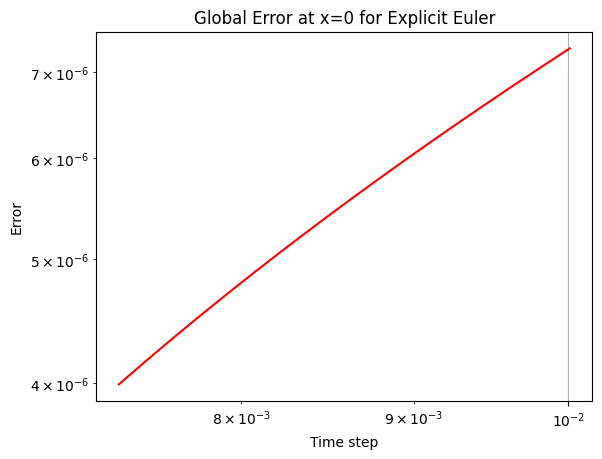

The gradient for the explicit Euler log-log plot is [ 1.96369034 -1.20358219] .


In [576]:
# Add code to plot error here
# Changing the temporal step
kappa = 0.001
euler_error = np.zeros(25)
N = np.arange(1000,1500,20) # A range of number of steps to take to get to t=10
stepsize = np.divide(10,N-1)

def true_solution(x,t,z):
  return (4*np.pi*z*(t+t_ic))**(-1/2)*np.exp((-x**2)/(4*z*(t+t_ic)))

t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
x_start = -1
x_end = 1
Nx = 401

for i in range(25):
  Nt = N[i]
  t = np.linspace(t_start, t_end, Nt)
  x = np.linspace(x_start, x_end, Nx)
  c_EE = EE(x, t, kappa)
  arg = int(3/4*(Nx-1))
  print(x[arg])
  euler_error[i] = np.abs(true_solution(0.5,t_end,kappa) - c_EE[arg,-1])



plt.loglog(stepsize[0:19], euler_error[0:19], 'r-')
plt.ylabel('Error')
plt.xlabel('Time step')
plt.title('Global Error at x=0 for Explicit Euler')
plt.grid()
plt.show()
m_EE = np.polyfit(np.log10(stepsize[0:19]), np.log10(euler_error[0:19]),1)
print('The gradient for the explicit Euler log-log plot is',m_EE,'.')

Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.05 seconds


/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.12 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.06 seconds


/tmp/ipython-input-2258080973.py:29: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('Explicit Euler','Crank-Nicholson')


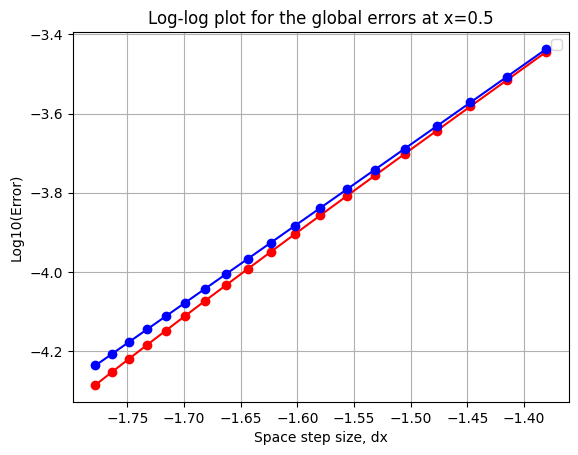

The gradient for the Euler log-log plot is [ 2.11457609 -0.52000148] .
The gradient for the Crank-Nicolson log-log plot is [ 2.01017121 -0.66282794] .


In [555]:
# Changing the spatial step

euler_error = np.zeros(20)
CN_error = np.zeros(20)
N = np.arange(49,129,4)
stepsize = np.divide(2,N-1)

def true_solution(x,t,z):
  return (4*np.pi*z*(t+t_ic))**(-1/2)*np.exp((-x**2)/(4*z*(t+t_ic)))

t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
x_start = -1
x_end = 1
Nt = 2001

for i in range(20):
  Nx = N[i]
  t = np.linspace(t_start, t_end, Nt)
  x = np.linspace(x_start, x_end, Nx)
  c_EE = EE(x, t, kappa)
  c_CN = CN(x, t, kappa)
  arg = int(3/4*(Nx-1))
  euler_error[i] = np.abs(true_solution(0.5,t_end,kappa) - c_EE[arg,-1])
  CN_error[i] = np.abs(true_solution(0.5,t_end,kappa) - c_CN[arg,-1])

plt.plot(np.log10(stepsize[0:19]), np.log10(euler_error[0:19]), 'ro-')
plt.plot(np.log10(stepsize[0:19]), np.log10(CN_error[0:19]), 'bo-')
plt.legend("Explicit Euler","Crank-Nicholson")
plt.ylabel('Log10(Error)')
plt.xlabel('Space step size, dx')
plt.title('Log-log plot for the global errors at x=0.5')
plt.grid()
plt.show()

m_EE = np.polyfit(np.log10(stepsize[0:19]), np.log10(euler_error[0:19]),1)
print('The gradient for the Euler log-log plot is',m_EE,'.')

m_CN = np.polyfit(np.log10(stepsize[0:19]), np.log10(CN_error[0:19]),1)
print('The gradient for the Crank-Nicolson log-log plot is',m_CN,'.')

can show analytically that CN is second order and EE is first order, but neither of the plots show this.

Can see that both are 2nd order in space, by the gradient of the log-log plots.

Haven't varied kappa but that is okay as you can scale out kappa into the t.

Require stability and also dominated by time/space where relevant.


Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

need to choose an error tolerance and use the error vs timestep graph from above (when it works properly!) to look at the speed of solutions at that error.

could plot error vs computation time plots and see when EE is better than CN and vice versa

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

### 2.3 Boundary conditions for Crank-Nicolson scheme
<a id='section2pt3'></a>

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This should ensure that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. Plot your results below and verify that the boundary conditions are satisfied.  How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

In [ ]:
ADD CODE AND PLOTS HERE

ADD DISCUSSION OF DIRICHLET AND NEUMANN BOUNDARY CONDITIONS HERE (NO CODE NEEDED)